In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import exploring_script as es
import importlib
importlib.reload(es)
import pandas as pd
import swifter
import numpy as np
from fink_utils.photometry.vect_conversion import vect_dc_mag

In [3]:
from swifter import set_defaults
set_defaults(
    npartitions=None,
    dask_threshold=1,
    scheduler="processes",
    progress_bar=True,
    progress_bar_desc=None,
    allow_dask_on_strings=False,
    force_parallel=True,
)

In [4]:
confirmed_sso = es.load_data(columns=["ssnamenr", "fid", 'magpsf', 'sigmapsf', 'magnr', 'sigmagnr', 'magzpsci', 'isdiffpos', "jd", "nid"])

In [5]:
confirmed_sso["dcmag"], confirmed_sso["sigdcmag"] = vect_dc_mag(
    confirmed_sso["fid"],
    confirmed_sso["magpsf"],
    confirmed_sso["sigmapsf"],
    confirmed_sso["magnr"],
    confirmed_sso["sigmagnr"],
    confirmed_sso["magzpsci"],
    confirmed_sso["isdiffpos"]
)

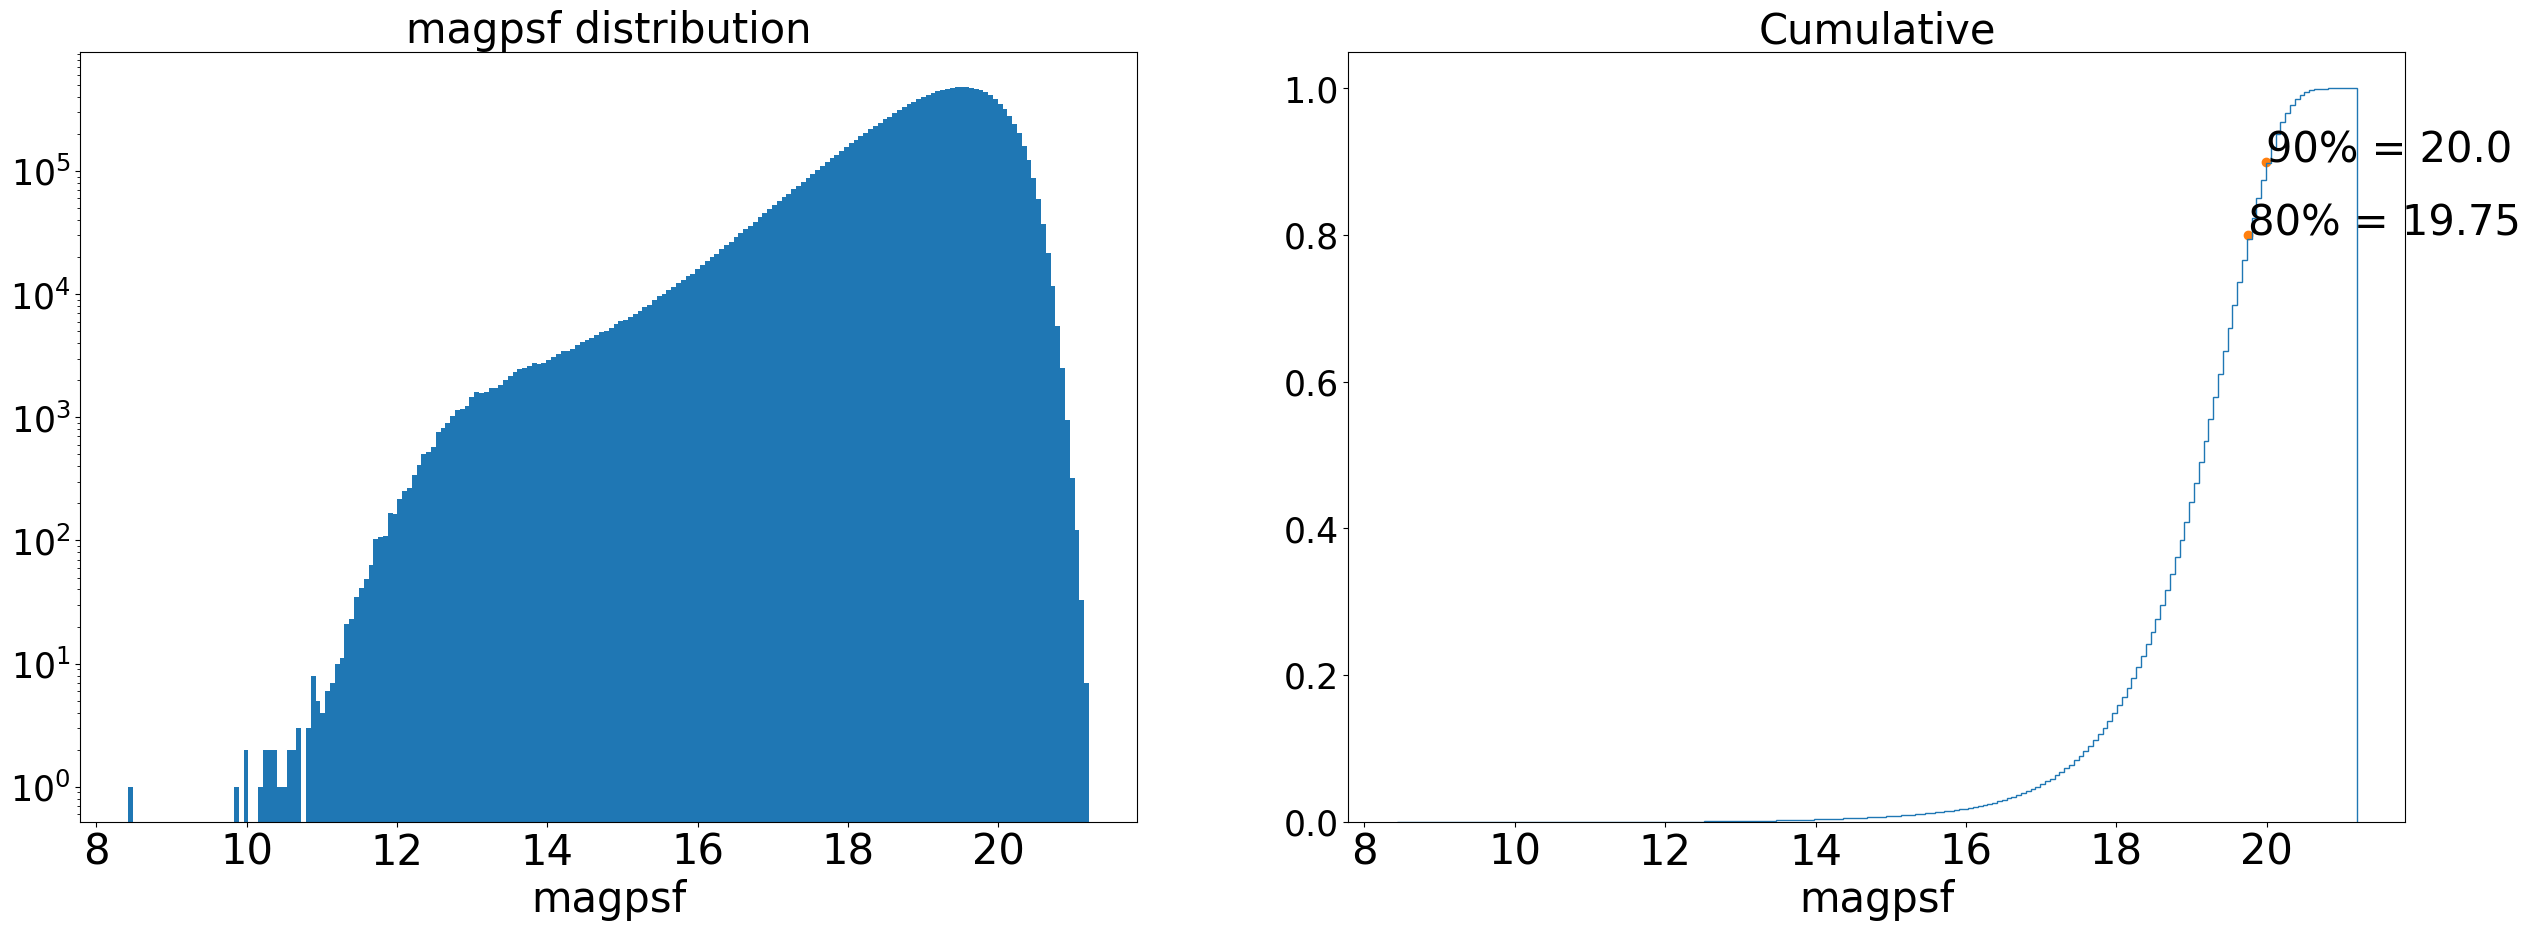

In [6]:
es.plot_hist_and_cdf(confirmed_sso["magpsf"], None, "magpsf distribution", "magpsf", "", None, "Cumulative", "magpsf", "")

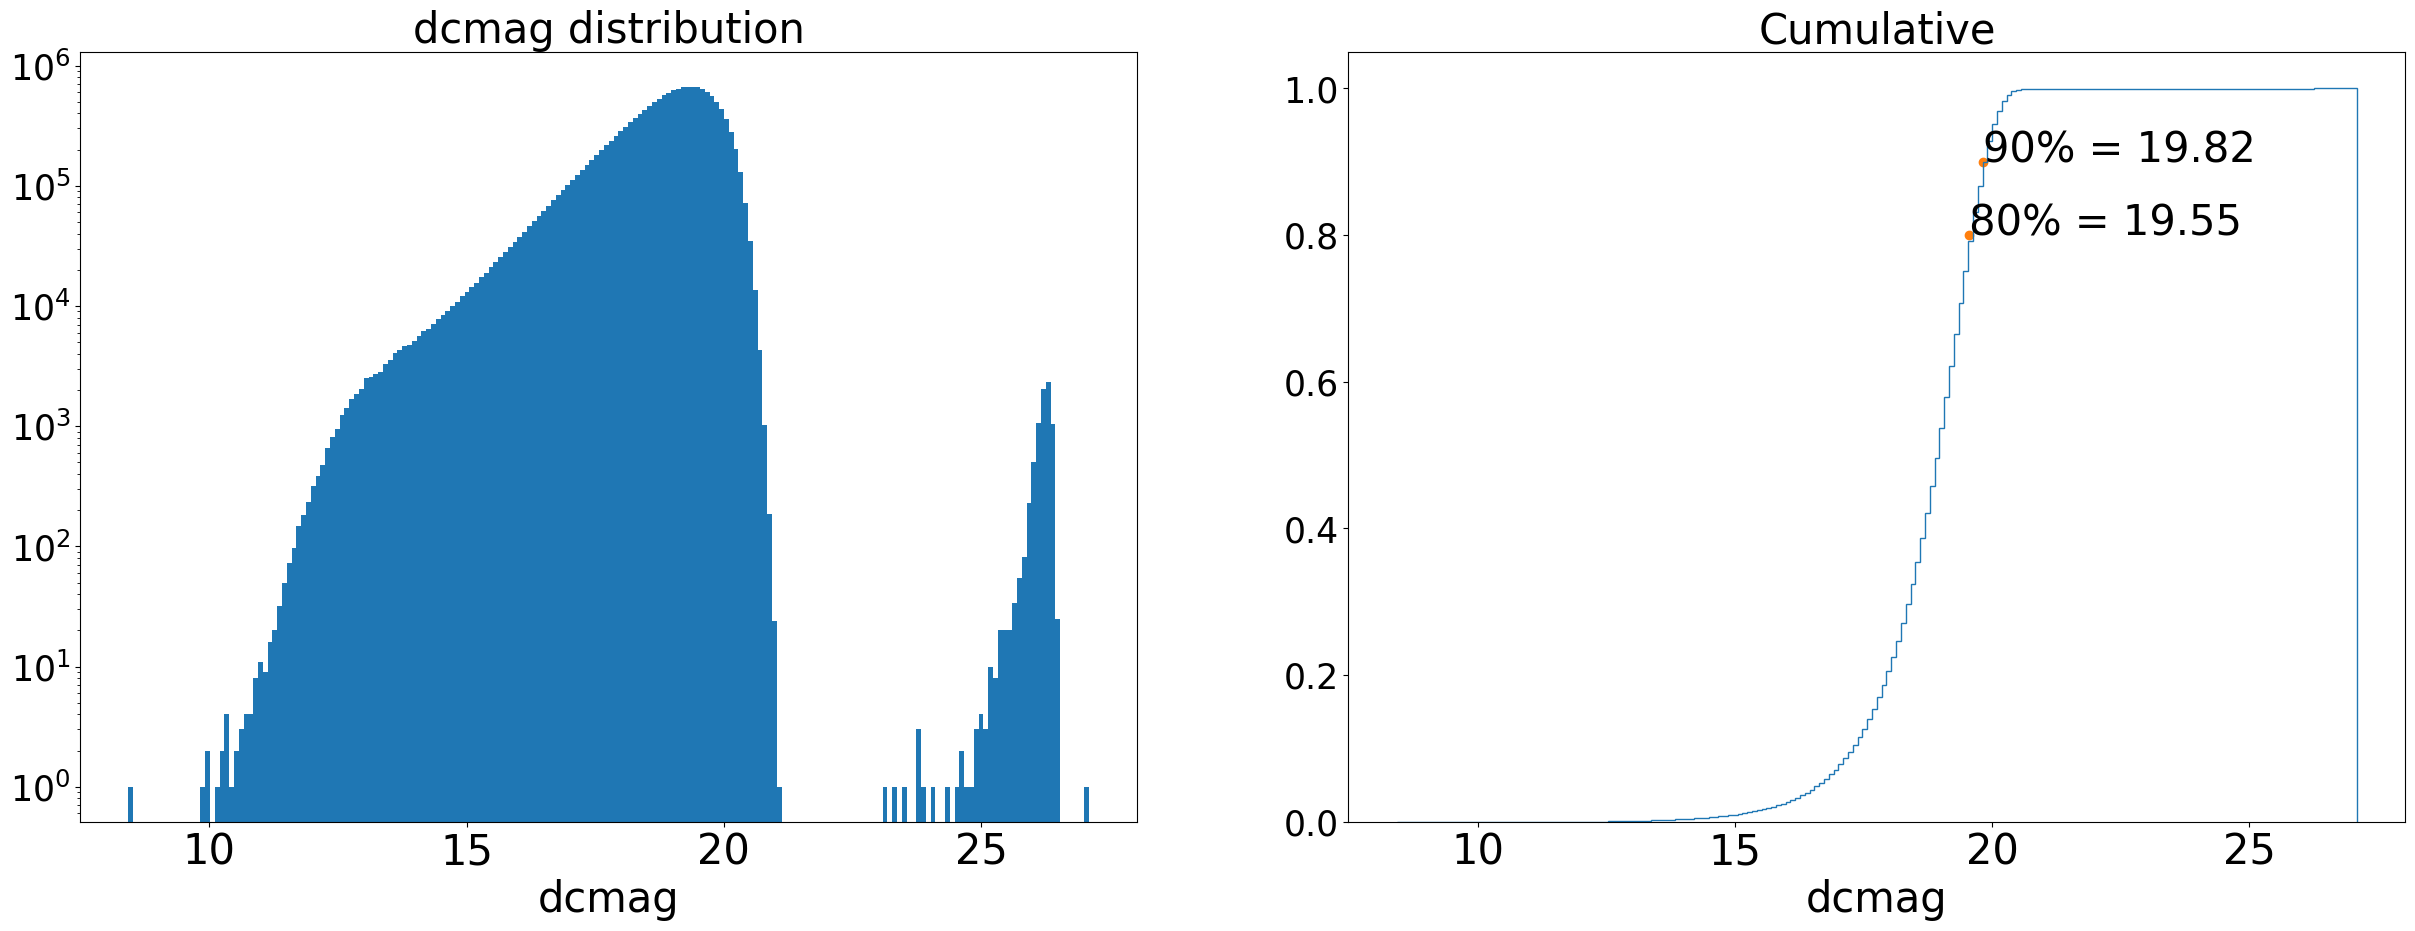

In [7]:
es.plot_hist_and_cdf(confirmed_sso["dcmag"], None, "dcmag distribution", "dcmag", "", None, "Cumulative", "dcmag", "")

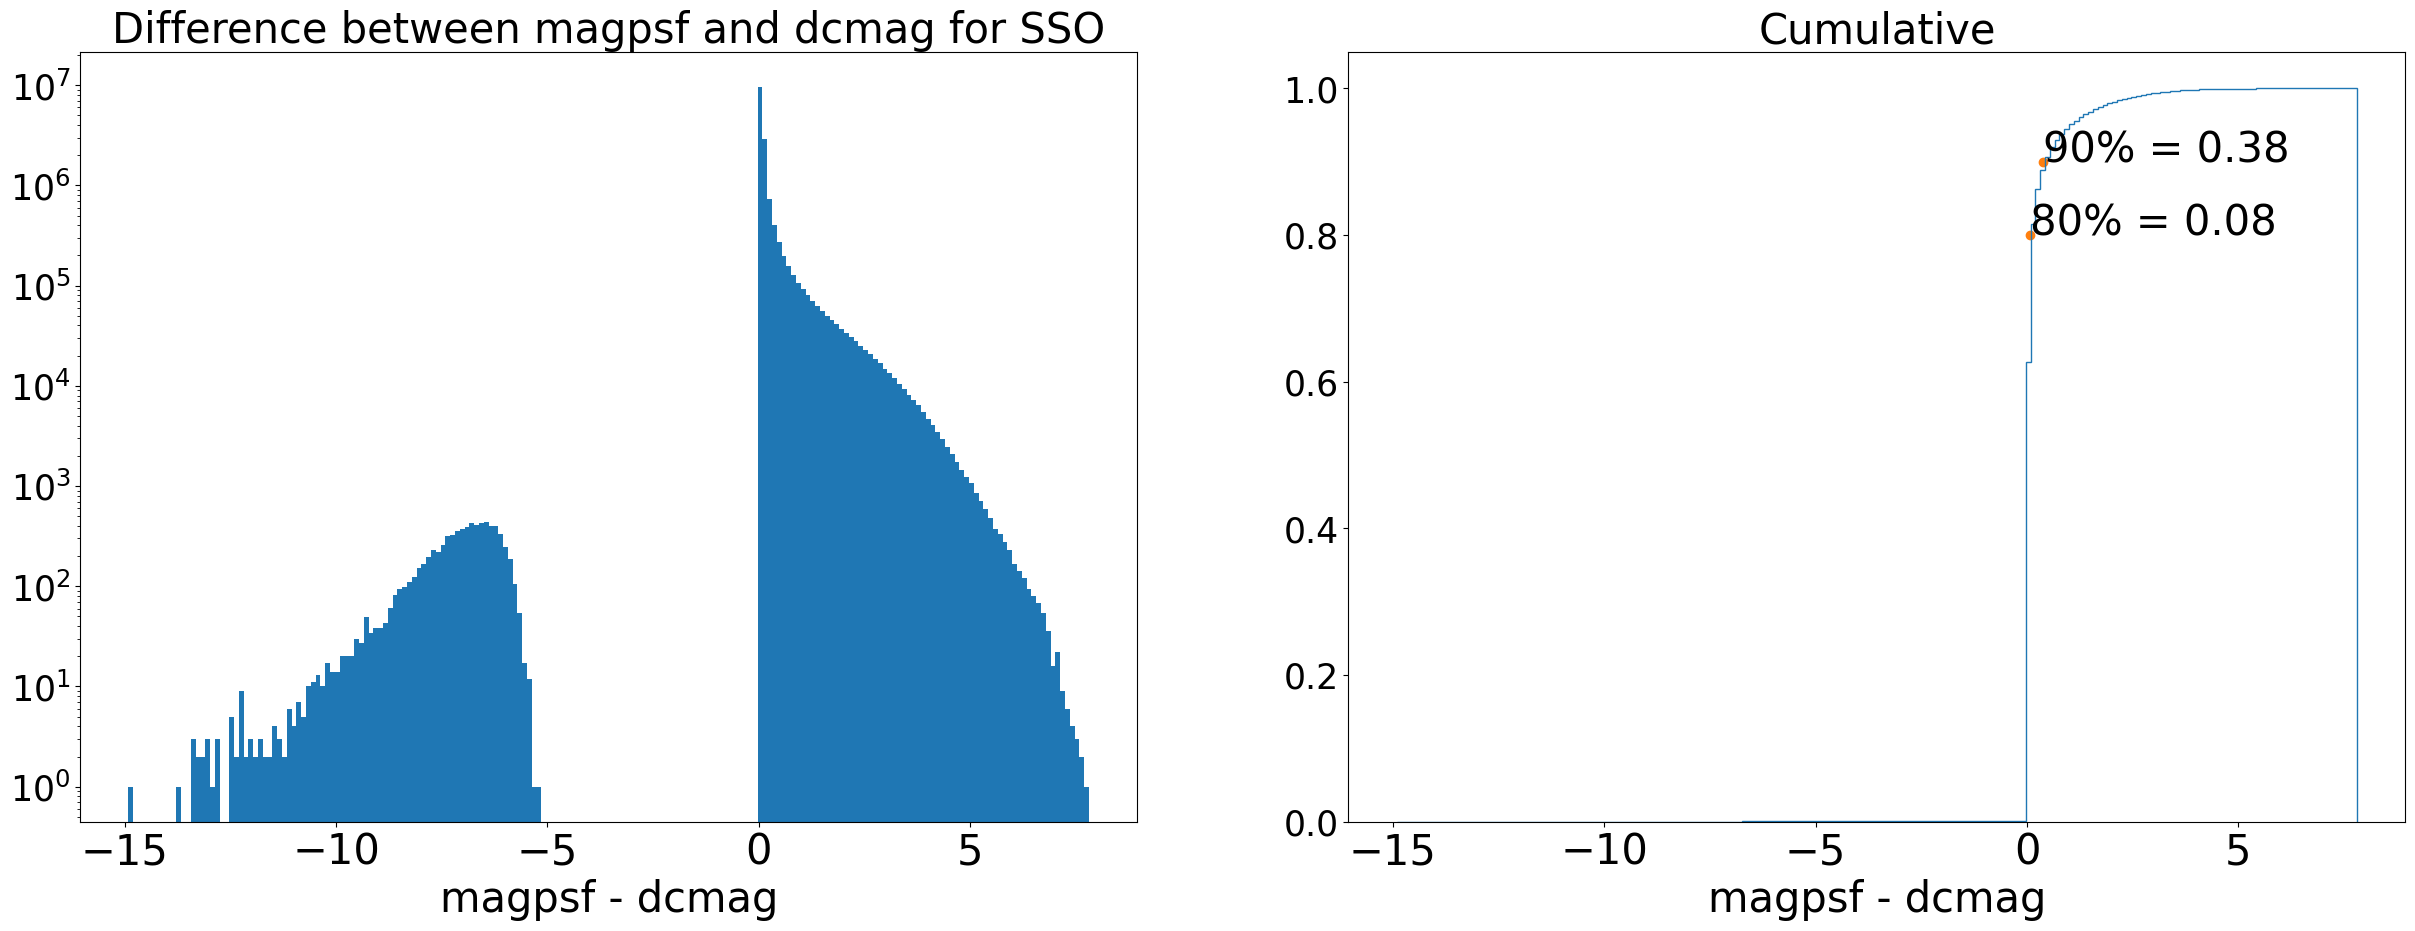

In [8]:
es.plot_hist_and_cdf((confirmed_sso["magpsf"] - confirmed_sso["dcmag"]), None, "Difference between magpsf and dcmag for SSO", "magpsf - dcmag", "", None, "Cumulative", "magpsf - dcmag", "")

In [9]:
prep_rate_gb = confirmed_sso.sort_values("jd").groupby("ssnamenr").agg(list)

In [10]:
rate_and_color = prep_rate_gb.swifter.apply(es.mag_df, axis=1)

Pandas Apply:   0%|          | 0/517611 [00:00<?, ?it/s]

In [11]:
rate_g = rate_and_color.explode().reset_index(drop=True)[::3].explode().reset_index(drop=True).replace([np.inf], np.nan).dropna()
rate_r = rate_and_color.explode().reset_index(drop=True)[1::3].explode().reset_index(drop=True).replace([np.inf], np.nan).dropna()
color = rate_and_color.explode().reset_index(drop=True)[2::3].explode().reset_index(drop=True)
color = color[color != 0]

/home/roman/anaconda3/envs/fink_fat_env/lib/python3.7/site-packages/swifter/swifter.py:88: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  "This pandas object has duplicate indices, "


### Magnitude study (all alerts)

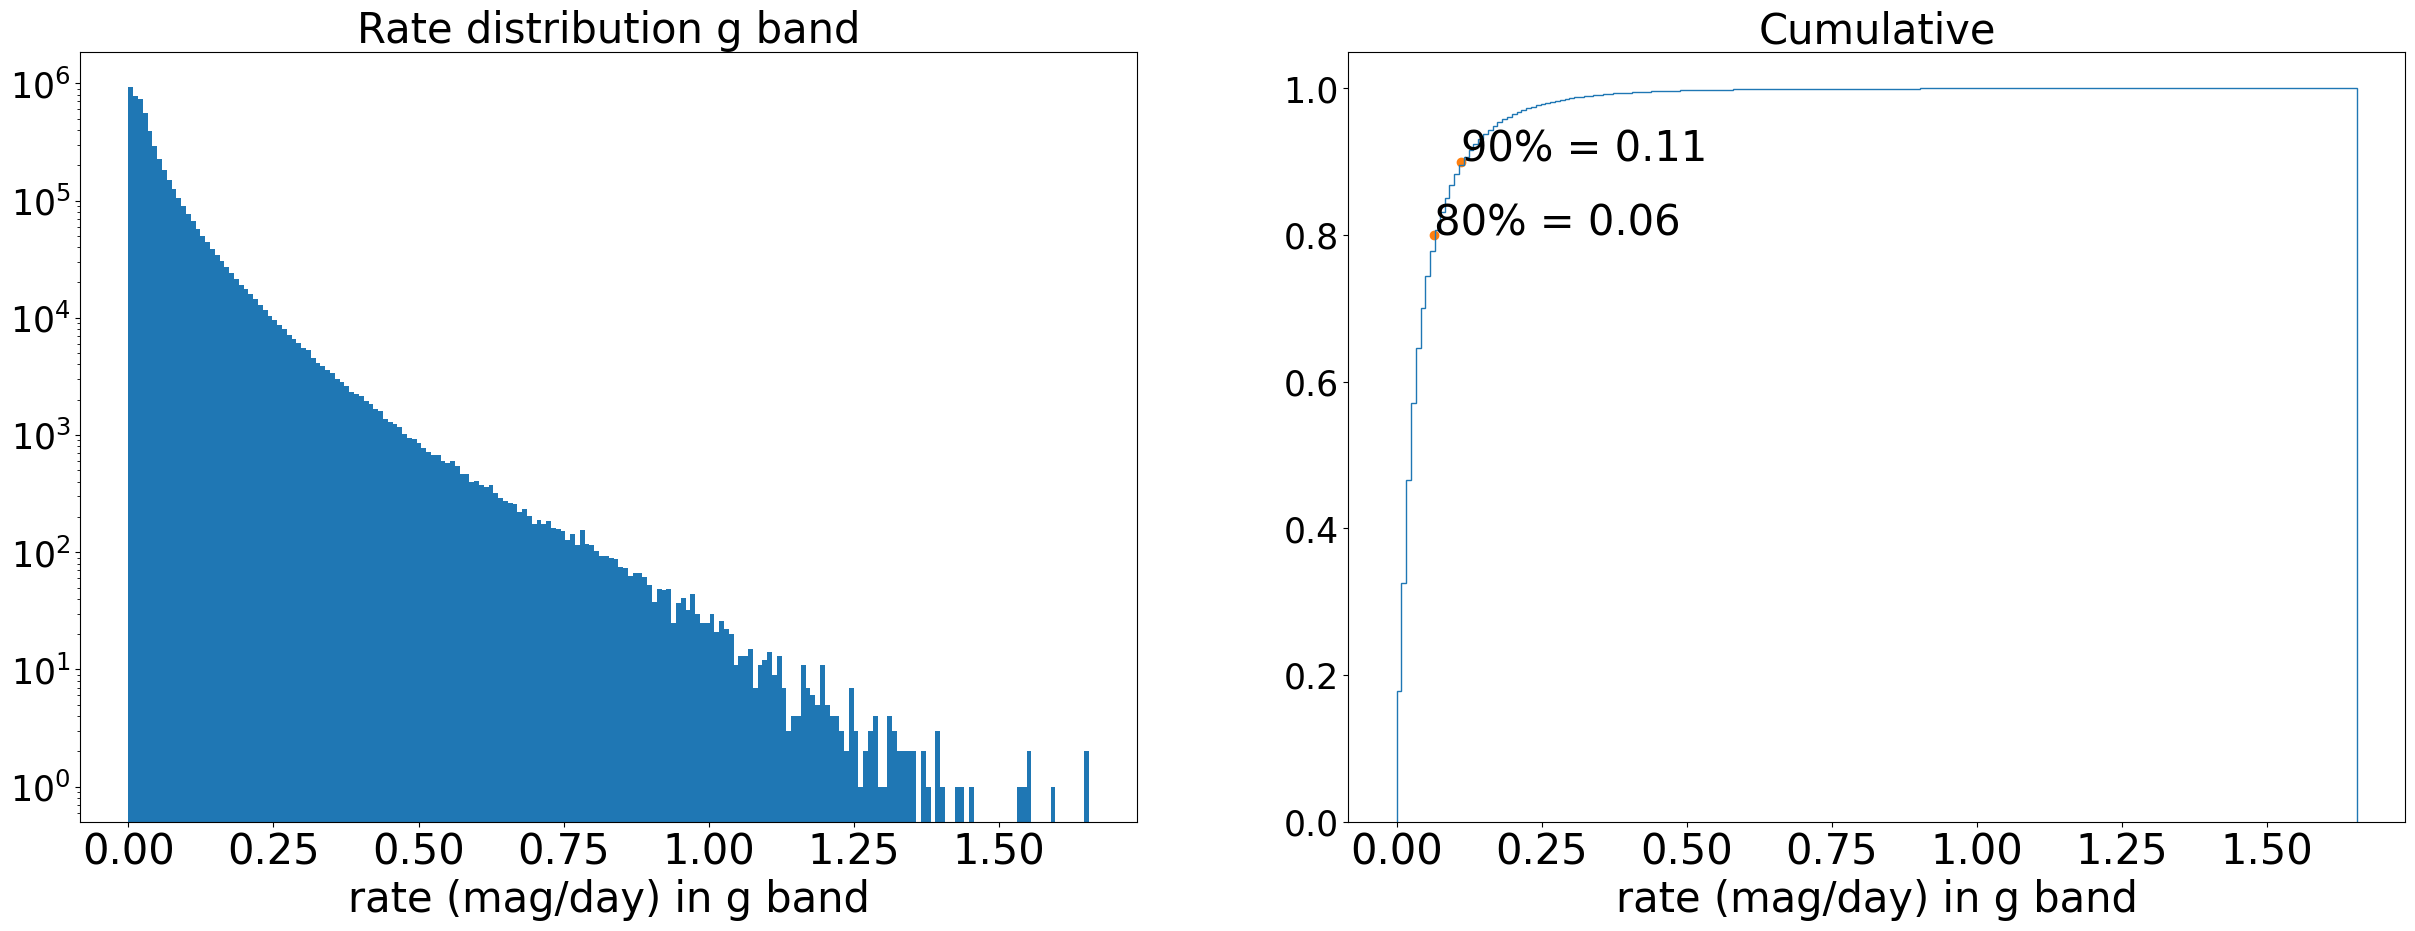

In [12]:
es.plot_hist_and_cdf(rate_g, None, "Rate distribution g band", "rate (mag/day) in g band", "", None, "Cumulative", "rate (mag/day) in g band", "")

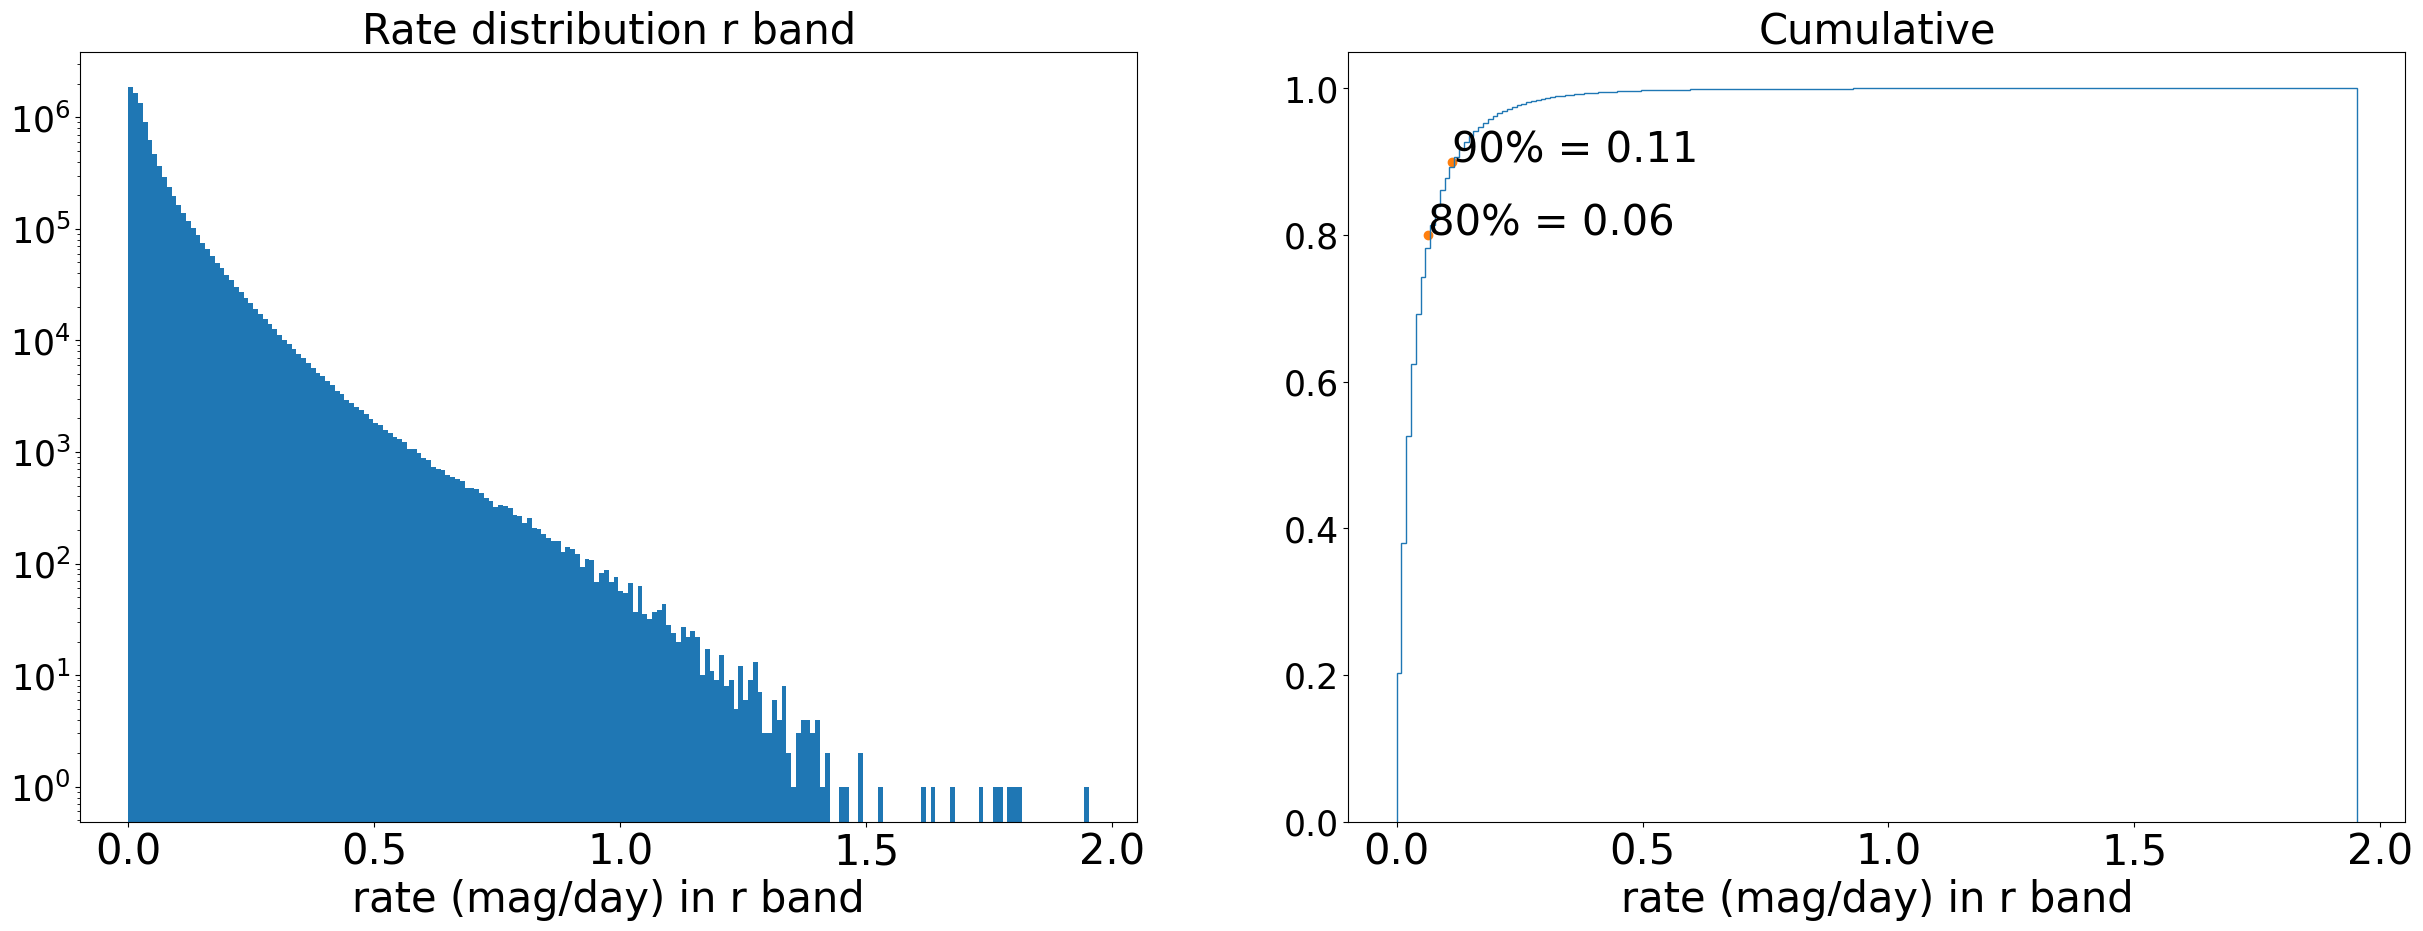

In [13]:
es.plot_hist_and_cdf(rate_r, None, "Rate distribution r band", "rate (mag/day) in r band", "", None, "Cumulative", "rate (mag/day) in r band", "")

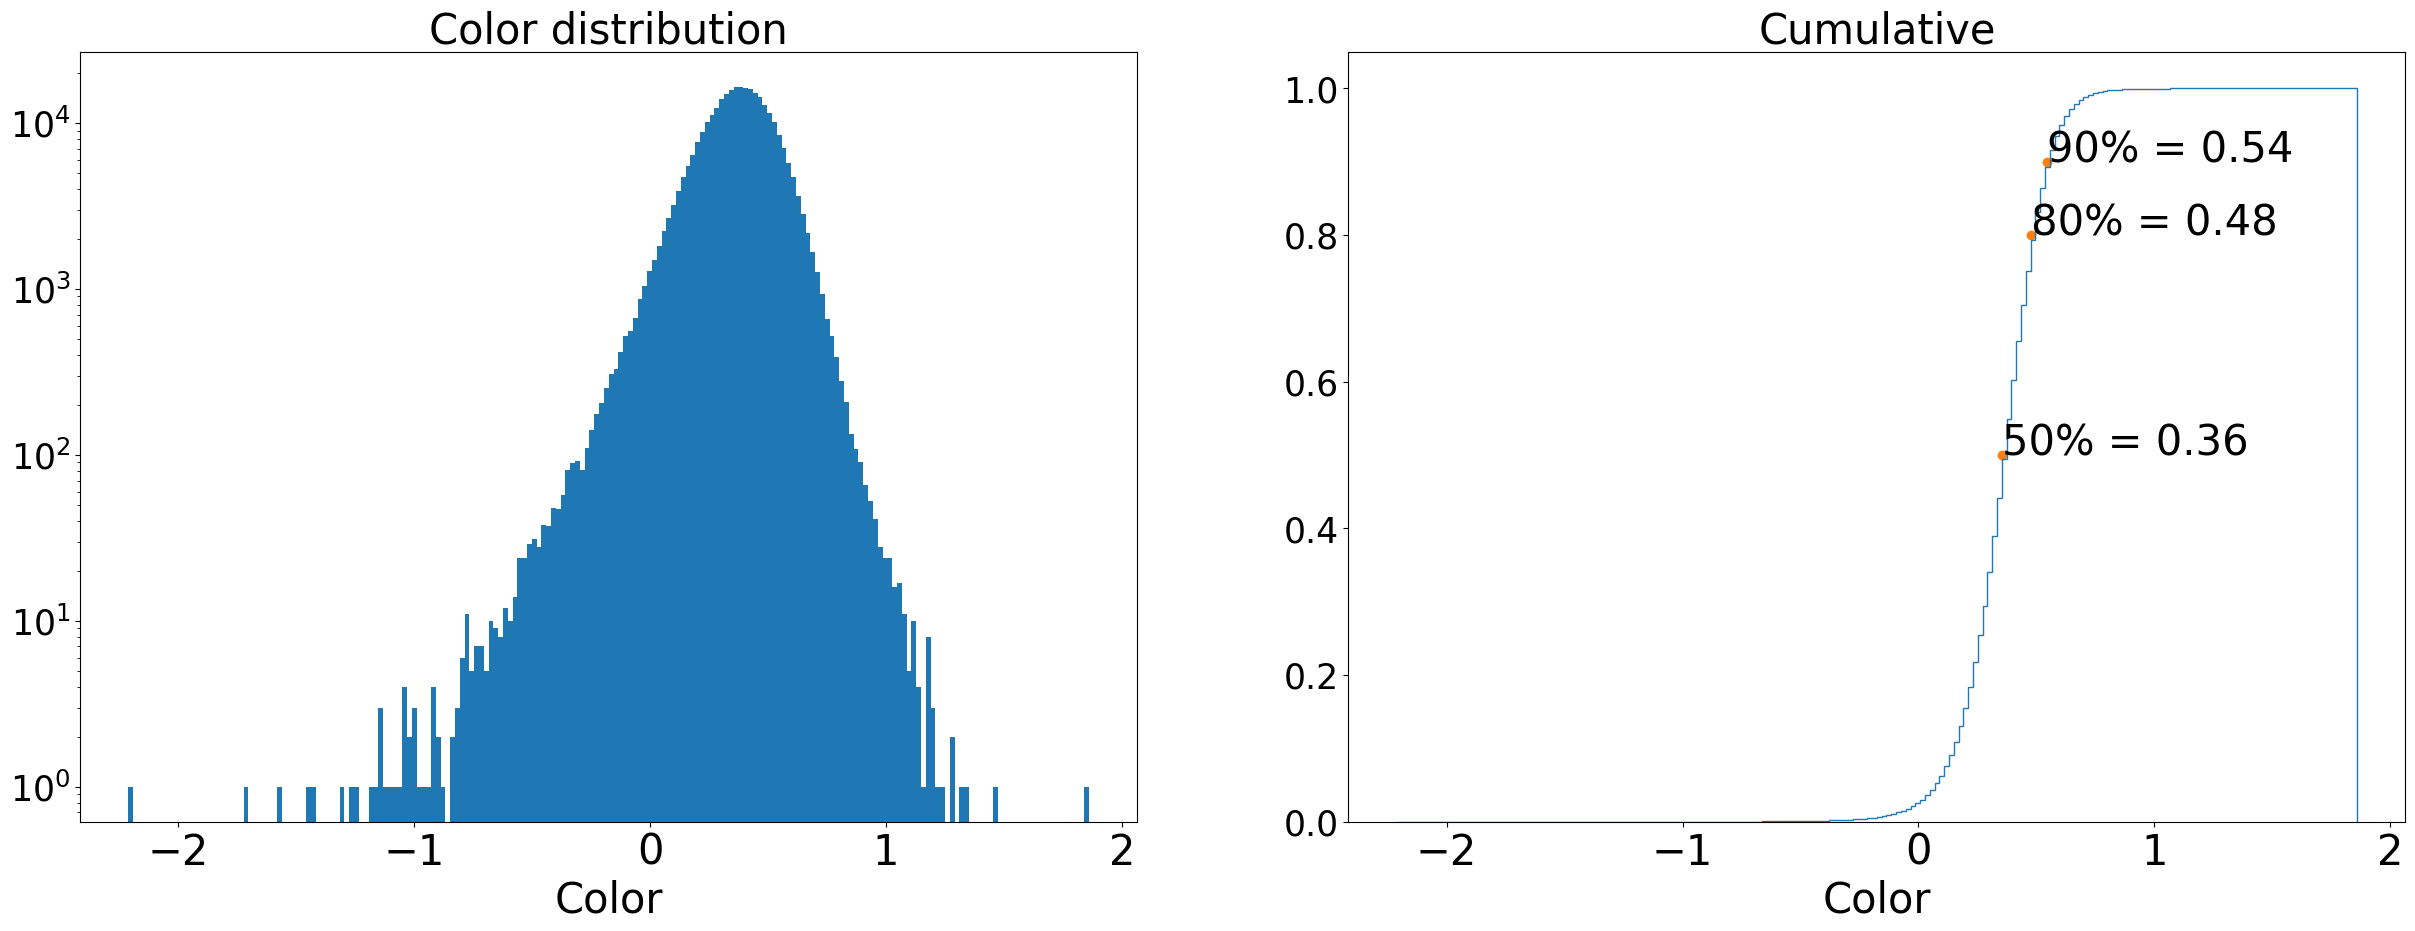

In [14]:
es.plot_hist_and_cdf(color, None, "Color distribution", "Color", "", None, "Cumulative", "Color", "", percent_cdf=[0.5, 0.8, 0.9])

### Magnitude study (intra night alerts)

In [20]:
prep_intra_rate_gb = confirmed_sso[["ssnamenr", "nid", "jd", "magpsf", "fid"]].sort_values("jd").groupby(["nid", "ssnamenr"]).agg(
    jd=("jd", list),
    magpsf=("magpsf", list),
    fid=("fid", list),
    nb_obs=("magpsf", len)
)

In [21]:
prep_intra_rate_gb

jd  \
nid  ssnamenr                                                        
1035 100005      [2458789.638125, 2458789.6663773, 2458789.8705...   
     100007      [2458789.6323148, 2458789.660463, 2458789.7603...   
     100012                                      [2458790.0073148]   
     10002                       [2458789.7060648, 2458789.728669]   
     100035                     [2458789.7678935, 2458789.8663889]   
...                                                            ...   
2188 9972                                        [2459942.7047454]   
     9988                                        [2459942.7056829]   
     99957                                       [2459942.7047454]   
     99978                                       [2459942.7061574]   
     C/2022QE78                                  [2459942.7102199]   

                                                            magpsf        fid  \
nid  ssnamenr                                                                   
1035 100005      [19.01654052734375, 19.526958465576172, 19.616...  [2, 1, 1]   
     100007      [18.95049476623535, 19.371076583862305, 19.006...  [2, 1, 2]   
     100012                                   [19.740392684936523]        [1]   
     10002                [18.008827209472656, 17.561664581298828]     [1, 2]   
     100035               [17.487789154052734, 18.068580627441406]     [2, 1]   
...                                                            ...        ...   
2188 9972                                      [18.32721710205078]        [2]   
     9988                                     [17.859010696411133]        [2]   
     99957                                    [18.801897048950195]        [2]   
     99978                                    [20.234893798828125]        [2]   
     C/2022QE78                               [18.647539138793945]        [2]   

                 nb_obs  
nid  ssnamenr            
1035 100005           3  
     100007           3  
     100012           1  
     10002            2  
     100035           2  
...                 ...  
2188 9972             1  
     9988             1  
     99957            1  
     99978            1  
     C/2022QE78       1  

[10371696 rows x 4 columns]

In [22]:
prep_intra_rate = prep_intra_rate_gb[prep_intra_rate_gb["nb_obs"] > 1]

In [24]:
intra_rate_and_color = prep_intra_rate.reset_index(drop=True).swifter.apply(es.mag_df, axis=1)

Pandas Apply:   0%|          | 0/4136628 [00:00<?, ?it/s]

In [25]:
intra_rate_g = intra_rate_and_color.explode().reset_index(drop=True)[::3].explode().reset_index(drop=True).replace([np.inf], np.nan).dropna()
intra_rate_r = intra_rate_and_color.explode().reset_index(drop=True)[1::3].explode().reset_index(drop=True).replace([np.inf], np.nan).dropna()
intra_color = intra_rate_and_color.explode().reset_index(drop=True)[2::3].explode().reset_index(drop=True)
intra_color = intra_color[intra_color != 0]

/home/roman/anaconda3/envs/fink_fat_env/lib/python3.7/site-packages/swifter/swifter.py:88: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  "This pandas object has duplicate indices, "


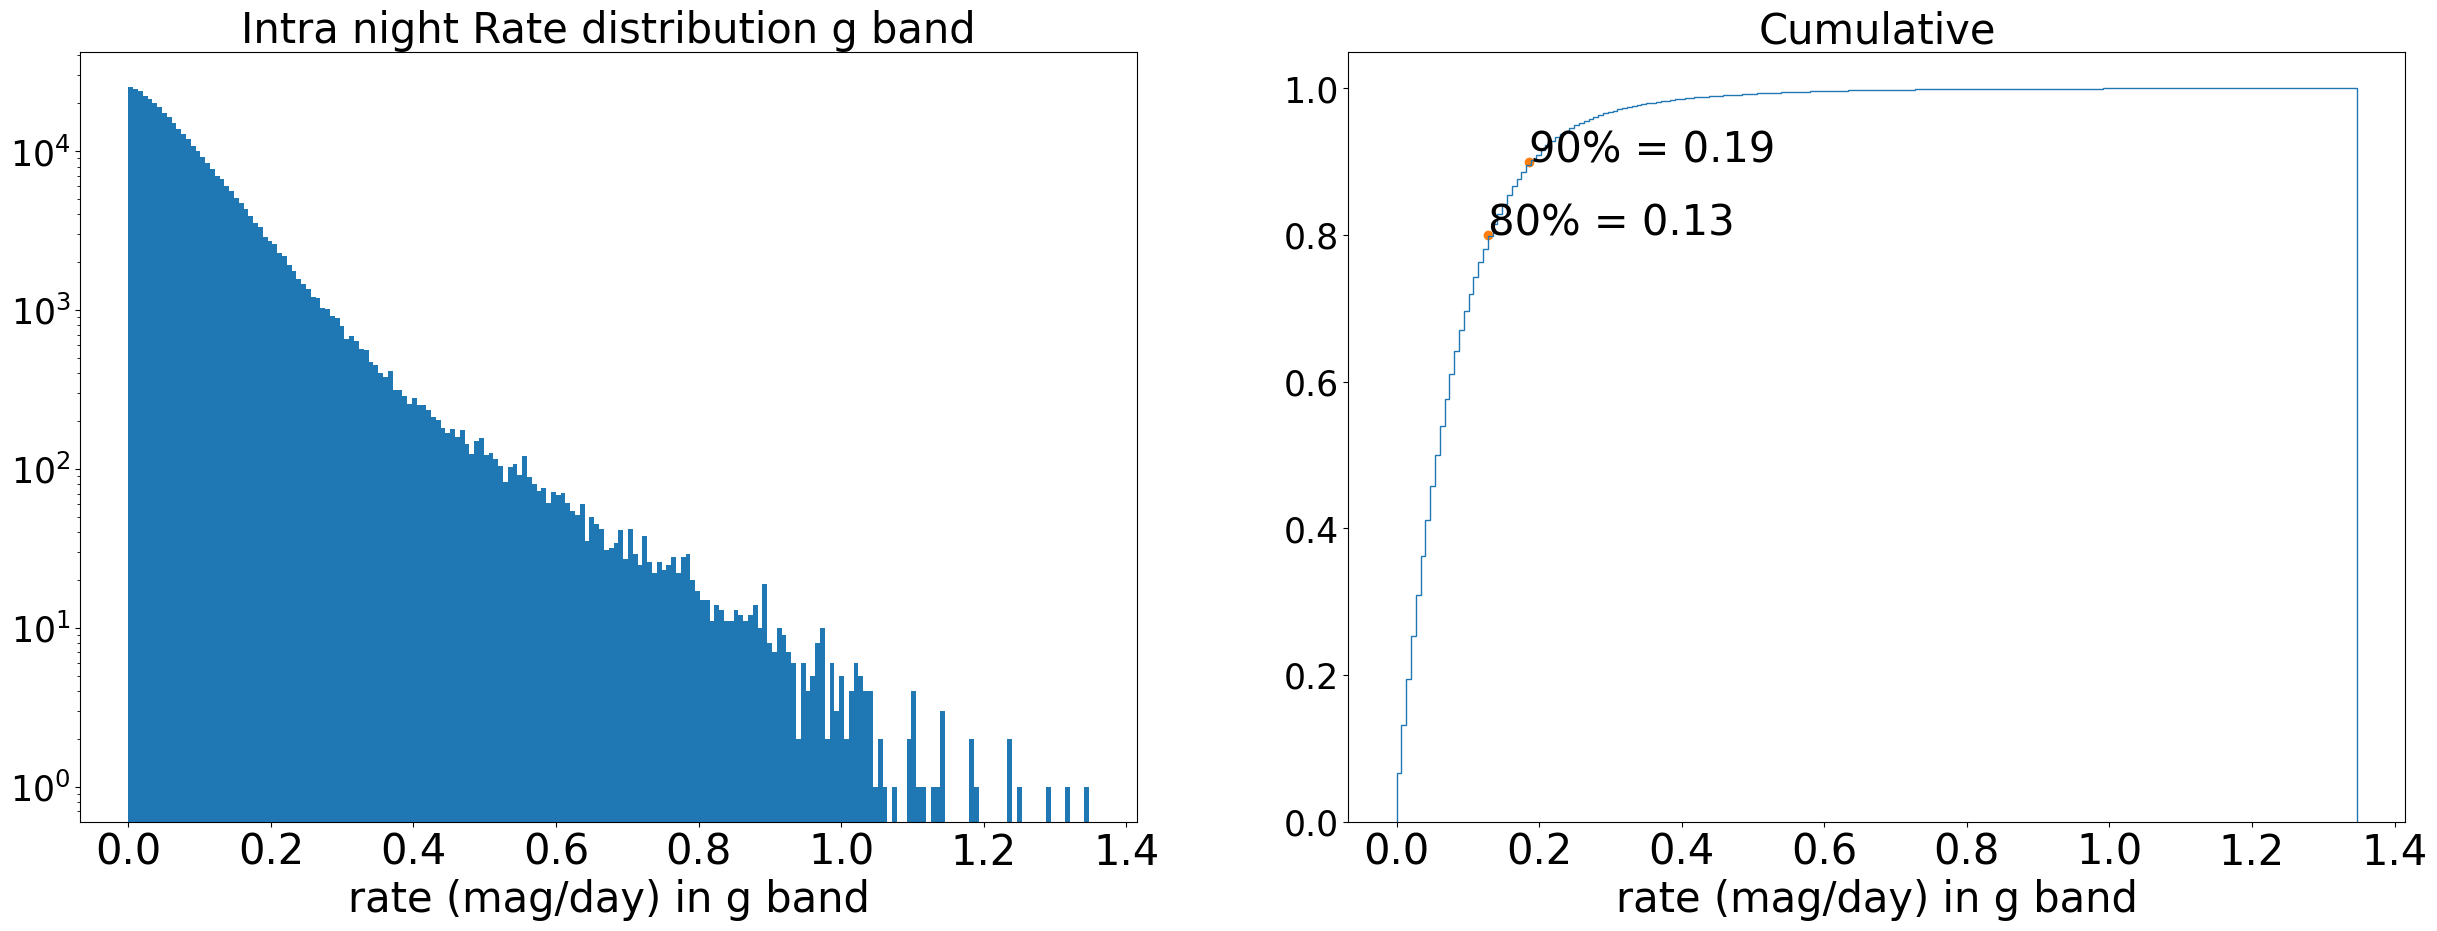

In [29]:
es.plot_hist_and_cdf(intra_rate_g, None, "Intra night Rate distribution g band", "rate (mag/day) in g band", "", None, "Cumulative", "rate (mag/day) in g band", "")

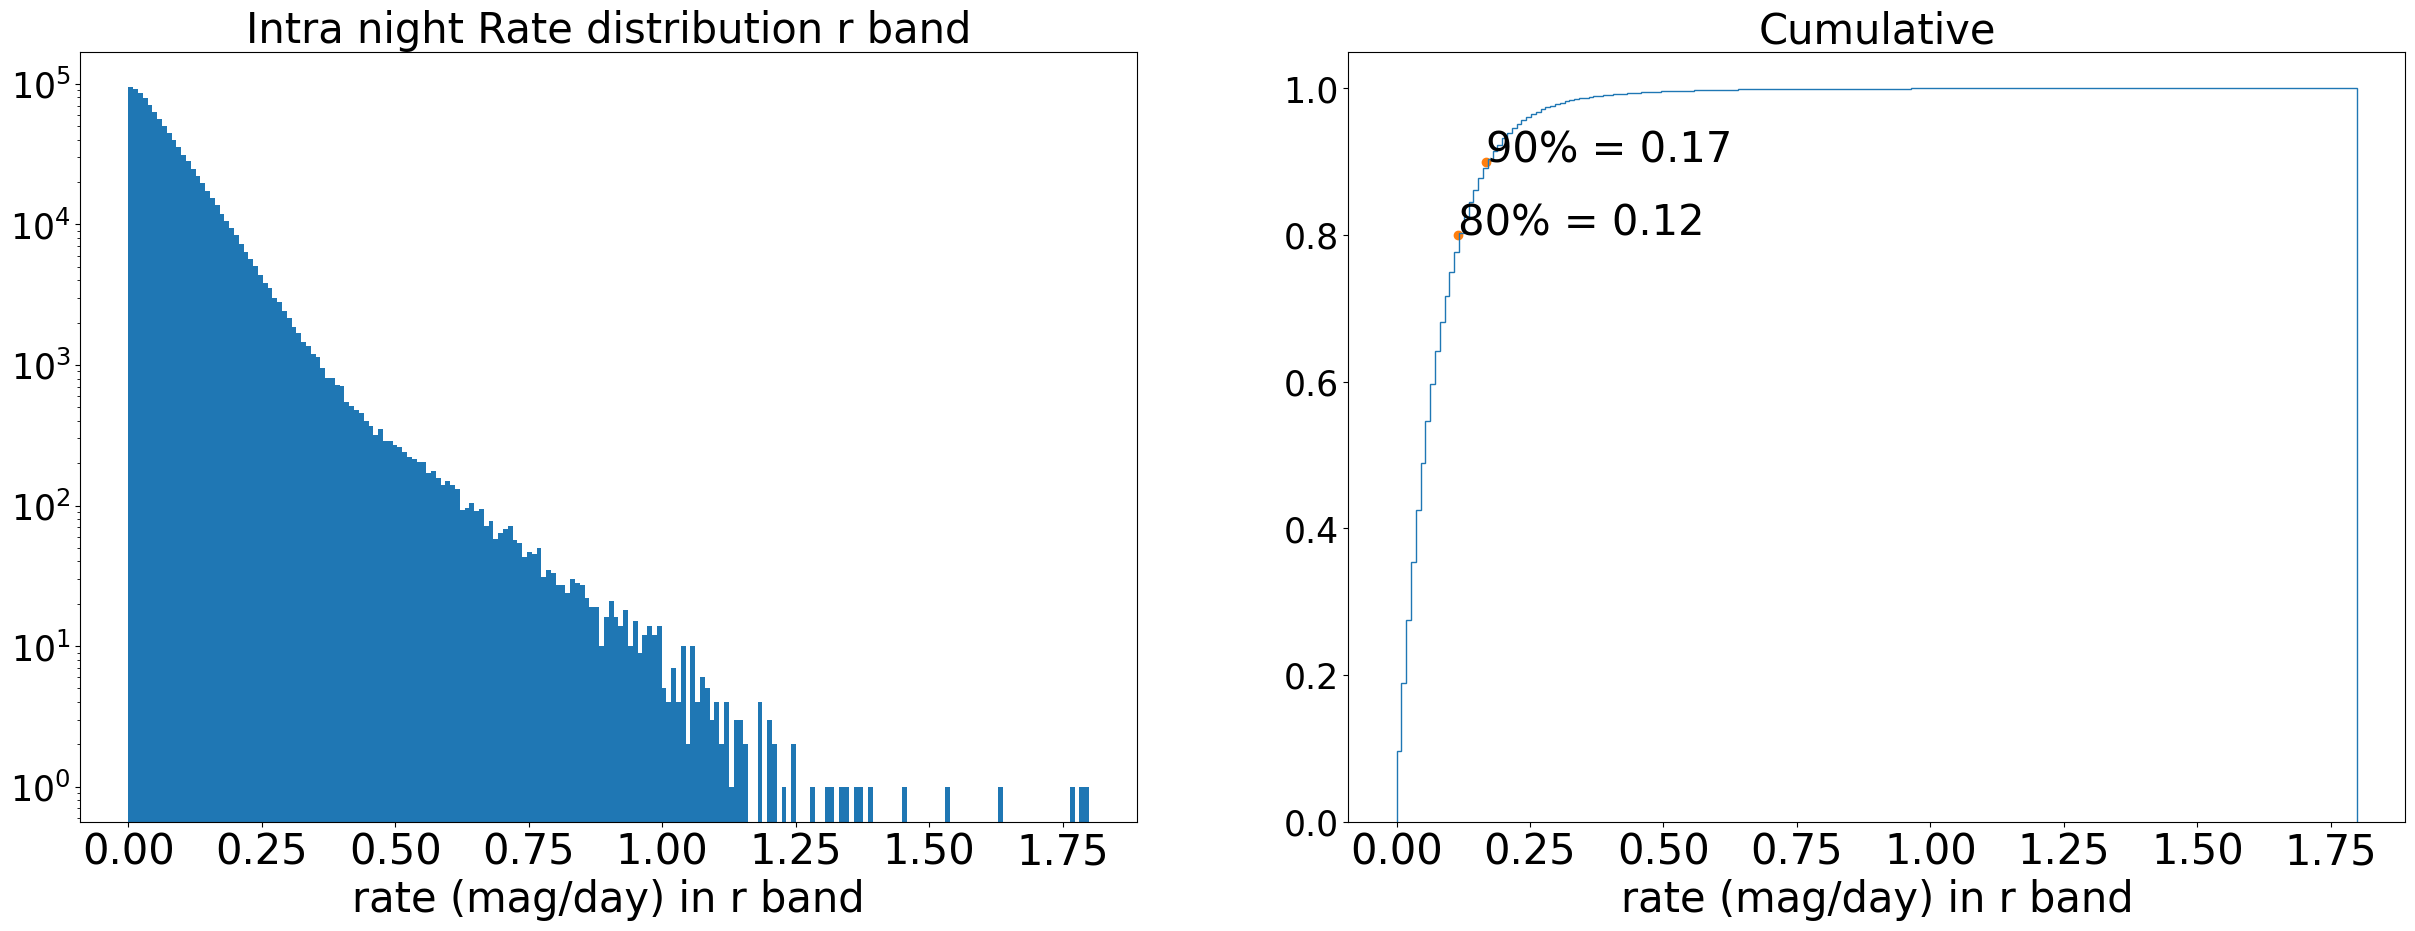

In [30]:
es.plot_hist_and_cdf(intra_rate_r, None, "Intra night Rate distribution r band", "rate (mag/day) in r band", "", None, "Cumulative", "rate (mag/day) in r band", "")

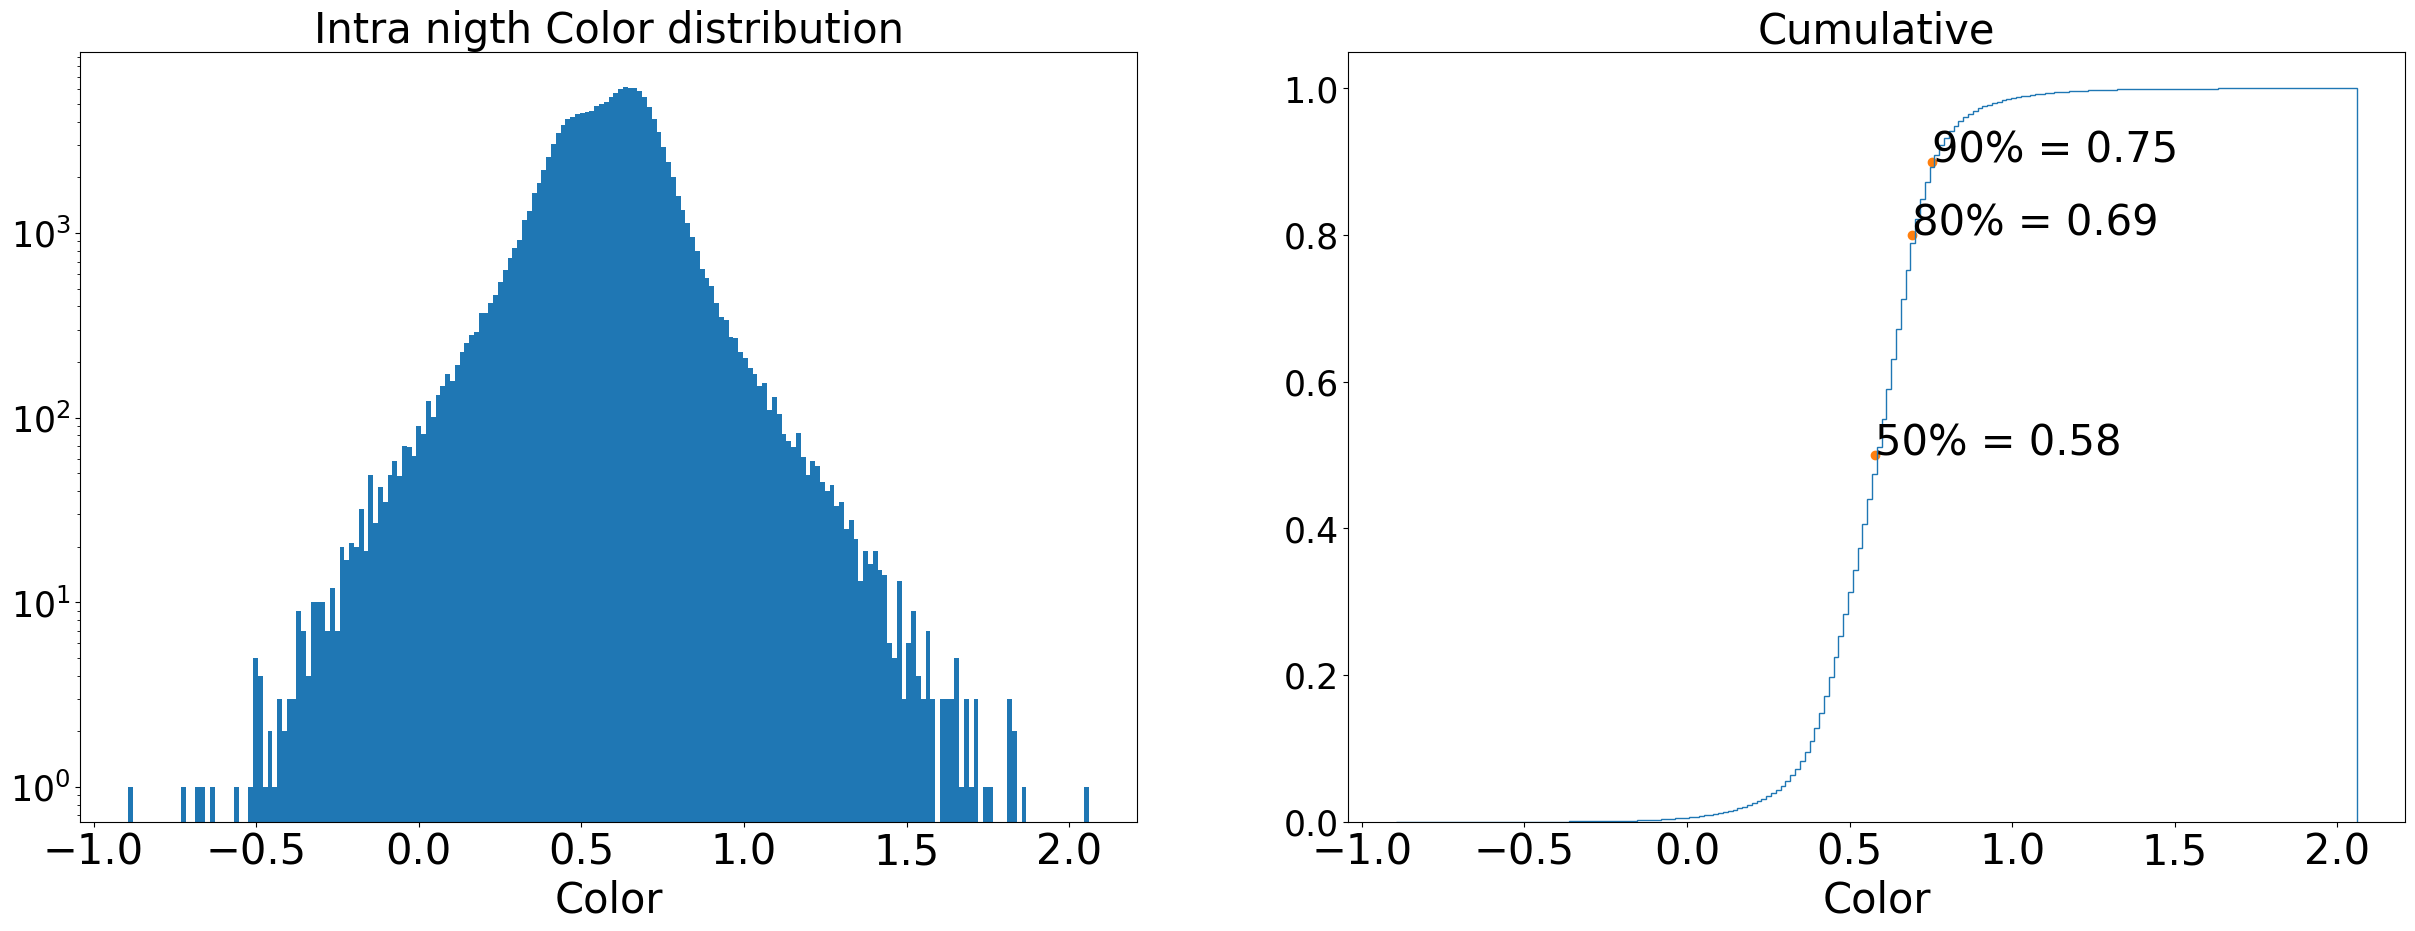

: 

In [31]:
es.plot_hist_and_cdf(intra_color, None, "Intra nigth Color distribution", "Color", "", None, "Cumulative", "Color", "", percent_cdf=[0.5, 0.8, 0.9])